In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
하천 수질 데이터와 기상 데이터 간의 상관성 분석
Author: 수질 분석 전문가
Date: 2025
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 통계 및 머신러닝 라이브러리
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# 시계열 분석
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows 환경)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [2]:
from datetime import datetime



class WaterQualityWeatherAnalyzer:
    """수질-기상 데이터 분석 클래스"""
    
    def __init__(self, file_path):
        """
        초기화
        Args:
            file_path (str): 엑셀 파일 경로
        """
        self.file_path = file_path
        self.data = None
        self.water_quality_cols = []
        self.weather_cols = []
        self.results = {}
        
    def load_data(self):
        """데이터 로딩 및 전처리"""
        print("데이터 로딩 중...")
        
        # 엑셀 파일 읽기
        self.data = pd.read_excel(self.file_path, engine='openpyxl', sheet_name=0) # 첫 번째 시트만 읽기
        
        # 컬럼명 정리
        self.data.columns = self.data.columns.str.strip()
        
        # 측정시간을 datetime으로 변환
        self.data['측정시간'] = pd.to_datetime(self.data['측정시간'])
        
        # 수질 지표와 기상 데이터 컬럼 분류
        self.water_quality_cols = [
            '수소이온농도', '용존산소', '전기전도도', '총유기탄소',
            '총질소', '총인', '클로로필-a', '남조류', '미생물독성_지수'
        ]
        
        self.weather_cols = [
            "기온(°C)", "강수량(mm)", "강수량(일누적)", "풍속(m/s)", "습도(%)", "증기압(hPa)", "이슬점온도(°C)",
            "현지기압(hPa)", "일조(hr)", "일조(누적)", "일사(MJ/m2)", "일사(누적)", "시정(10m)", "지면온도(°C)"
        ]
        
        # 숫자형 데이터로 변환 (빈 문자열은 NaN으로)
        for col in self.water_quality_cols + self.weather_cols:
            if col in self.data.columns:
                self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        
        print(f"데이터 로딩 완료: {len(self.data)}행 × {len(self.data.columns)}열")
        print(f"기간: {self.data['측정시간'].min()} ~ {self.data['측정시간'].max()}")

    # def load_data(self):
    #     """데이터 로딩 및 전처리"""
    #     print("데이터 로딩 중...")
        
    #     # 엑셀 파일 읽기
    #     self.data = pd.read_excel(self.file_path)
        
    #     # 컬럼명 정리
    #     self.data.columns = self.data.columns.str.strip()
        
    #     # 실제 컬럼명 확인
    #     print("실제 컬럼명들:")
    #     print(list(self.data.columns))
        
    #     # 시간 관련 컬럼 찾기
    #     time_columns = [col for col in self.data.columns if '시간' in col or '일시' in col or 'time' in col.lower() or 'date' in col.lower()]
    #     print(f"시간 관련 컬럼들: {time_columns}")
        
    #     if not time_columns:
    #         print("시간 컬럼을 찾을 수 없습니다. 첫 번째 컬럼을 시간으로 사용합니다.")
    #         time_col = self.data.columns[0]
    #     else:
    #         time_col = time_columns[0]
        
    #     print(f"사용할 시간 컬럼: {time_col}")
        
    #     # 측정시간을 datetime으로 변환
    #     self.data['측정시간'] = pd.to_datetime(self.data[time_col], errors='coerce')
        
    #     # 수질 지표와 기상 데이터 컬럼 분류 (실제 존재하는 컬럼만)
    #     potential_water_cols = [
    #         '수소이온농도', '용존산소', '전기전도도', '수온', '총유기탄소',
    #         '총질소', '총인', '클로로필-a', '남조류', '미생물 독성지수'
    #     ]
        
    #     potential_weather_cols = [
    #         '기상_2.기온(°C)', '기상_2.강수량(mm)', '기상_2.풍속(m/s)',
    #         '기상_2.습도(%)', '기상_2.증기압(hPa)', '기상_2.이슬점온도(°C)',
    #         '기상_2.현지기압(hPa)', '기상_2.해면기압(hPa)', '기상_2.일조(hr)',
    #         '기상_2.일사(MJ/m2)', '기상_2.지면온도(°C)'
    #     ]
        
    #     # 실제 존재하는 컬럼만 필터링
    #     self.water_quality_cols = [col for col in potential_water_cols if col in self.data.columns]
    #     self.weather_cols = [col for col in potential_weather_cols if col in self.data.columns]
        
    #     print(f"찾은 수질 컬럼들 ({len(self.water_quality_cols)}개): {self.water_quality_cols}")
    #     print(f"찾은 기상 컬럼들 ({len(self.weather_cols)}개): {self.weather_cols}")
        
    #     # 숫자형 데이터로 변환 (빈 문자열은 NaN으로)
    #     for col in self.water_quality_cols + self.weather_cols:
    #         if col in self.data.columns:
    #             self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        
    #     print(f"데이터 로딩 완료: {len(self.data)}행 × {len(self.data.columns)}열")
    #     if '측정시간' in self.data.columns and not self.data['측정시간'].isna().all():
    #         print(f"기간: {self.data['측정시간'].min()} ~ {self.data['측정시간'].max()}")


    def basic_statistics(self):
        """기본 통계 정보"""
        print("\n=== 기본 통계 정보 ===")
        
        # 수질 데이터 기본 통계
        water_quality_data = self.data[self.water_quality_cols].dropna()
        weather_data = self.data[self.weather_cols].dropna()
        
        print("\n[수질 지표 기본 통계]")
        print(water_quality_data.describe())
        
        print("\n[기상 데이터 기본 통계]")
        print(weather_data.describe())
        
        # 결측값 확인
        print("\n[결측값 현황]")
        missing_info = pd.DataFrame({
            '결측값_개수': self.data.isnull().sum(),
            '결측값_비율(%)': (self.data.isnull().sum() / len(self.data) * 100).round(2)
        })
        print(missing_info[missing_info['결측값_개수'] > 0])
        
        self.results['basic_stats'] = {
            'water_quality': water_quality_data.describe(),
            'weather': weather_data.describe(),
            'missing_values': missing_info
        }
        
    def correlation_analysis(self):
        """상관성 분석"""
        print("\n=== 상관성 분석 ===")
        
        # 수질-기상 데이터 결합
        analysis_data = self.data[self.water_quality_cols + self.weather_cols].dropna()
        
        # Pearson 상관계수 계산
        pearson_corr = analysis_data.corr(method='pearson')
        
        # Spearman 상관계수 계산
        spearman_corr = analysis_data.corr(method='spearman')
        
        # 수질-기상 간 상관계수 추출
        water_weather_pearson = pearson_corr.loc[self.water_quality_cols, self.weather_cols]
        water_weather_spearman = spearman_corr.loc[self.water_quality_cols, self.weather_cols]
        
        print("\n[수질-기상 Pearson 상관계수]")
        print(water_weather_pearson.round(3))
        
        print("\n[수질-기상 Spearman 상관계수]")
        print(water_weather_spearman.round(3))
        
        # 유의한 상관관계 찾기 (|r| > 0.3)
        significant_correlations = []
        for water_col in self.water_quality_cols:
            for weather_col in self.weather_cols:
                if water_col in analysis_data.columns and weather_col in analysis_data.columns:
                    pearson_r = water_weather_pearson.loc[water_col, weather_col]
                    if abs(pearson_r) > 0.3:
                        significant_correlations.append({
                            '수질지표': water_col,
                            '기상요소': weather_col,
                            'Pearson_r': round(pearson_r, 3),
                            'Spearman_r': round(water_weather_spearman.loc[water_col, weather_col], 3)
                        })
        
        sig_corr_df = pd.DataFrame(significant_correlations).sort_values('Pearson_r', key=abs, ascending=False)
        print(f"\n[유의한 상관관계 (|r| > 0.3): {len(sig_corr_df)}개]")
        print(sig_corr_df)
        
        self.results['correlation'] = {
            'pearson': water_weather_pearson,
            'spearman': water_weather_spearman,
            'significant': sig_corr_df
        }
        
        return water_weather_pearson, water_weather_spearman
    
    def regression_analysis(self):
        """회귀분석"""
        print("\n=== 회귀분석 ===")
        
        regression_results = {}
        analysis_data = self.data[self.water_quality_cols + self.weather_cols].dropna()
        
        for water_col in self.water_quality_cols:
            if water_col in analysis_data.columns:
                print(f"\n[{water_col} 회귀분석]")
                
                y = analysis_data[water_col]
                X = analysis_data[self.weather_cols]
                
                # 다중선형회귀
                lr = LinearRegression()
                lr.fit(X, y)
                y_pred = lr.predict(X)
                
                # R-squared 계산
                r2 = r2_score(y, y_pred)
                rmse = np.sqrt(mean_squared_error(y, y_pred))
                
                # 회귀계수
                coef_df = pd.DataFrame({
                    '변수': X.columns,
                    '회귀계수': lr.coef_,
                    '절댓값': np.abs(lr.coef_)
                }).sort_values('절댓값', ascending=False)
                
                print(f"R-squared: {r2:.3f}")
                print(f"RMSE: {rmse:.3f}")
                print("주요 영향 요인:")
                print(coef_df.head())
                
                regression_results[water_col] = {
                    'r2': r2,
                    'rmse': rmse,
                    'coefficients': coef_df,
                    'intercept': lr.intercept_
                }
        
        self.results['regression'] = regression_results
        
    def random_forest_analysis(self):
        """랜덤포레스트 특성 중요도 분석"""
        print("\n=== 랜덤포레스트 특성 중요도 분석 ===")
        
        rf_results = {}
        analysis_data = self.data[self.water_quality_cols + self.weather_cols].dropna()
        
        for water_col in self.water_quality_cols:
            if water_col in analysis_data.columns:
                y = analysis_data[water_col]
                X = analysis_data[self.weather_cols]
                
                # 랜덤포레스트 모델
                rf = RandomForestRegressor(n_estimators=100, random_state=42)
                rf.fit(X, y)
                
                # 특성 중요도
                importance_df = pd.DataFrame({
                    '기상요소': X.columns,
                    '중요도': rf.feature_importances_
                }).sort_values('중요도', ascending=False)
                
                print(f"\n[{water_col} - 기상요소 중요도]")
                print(importance_df)
                
                rf_results[water_col] = importance_df
        
        self.results['random_forest'] = rf_results
        
    def time_series_analysis(self):
        """시계열 분석"""
        print("\n=== 시계열 분석 ===")
        
        # 날짜별 평균값 계산
        daily_data = self.data.groupby(self.data['측정시간'].dt.date)[
            self.water_quality_cols + self.weather_cols
        ].mean()
        
        ts_results = {}
        
        for col in self.water_quality_cols:
            if col in daily_data.columns and not daily_data[col].isna().all():
                ts_data = daily_data[col].dropna()
                
                if len(ts_data) > 10:  # 충분한 데이터가 있을 때만
                    # 정상성 검정 (ADF 테스트)
                    adf_result = adfuller(ts_data)
                    
                    print(f"\n[{col} 시계열 분석]")
                    print(f"ADF 통계량: {adf_result[0]:.3f}")
                    print(f"p-value: {adf_result[1]:.3f}")
                    print(f"정상성: {'정상' if adf_result[1] < 0.05 else '비정상'}")
                    
                    ts_results[col] = {
                        'adf_statistic': adf_result[0],
                        'p_value': adf_result[1],
                        'is_stationary': adf_result[1] < 0.05
                    }
        
        self.results['time_series'] = ts_results
        
    def pca_analysis(self):
        """주성분 분석"""
        print("\n=== 주성분 분석 ===")
        
        analysis_data = self.data[self.water_quality_cols + self.weather_cols].dropna()
        
        # 데이터 표준화
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(analysis_data)
        
        # PCA 수행
        pca = PCA()
        pca_data = pca.fit_transform(scaled_data)
        
        # 설명분산비
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)
        
        print(f"주성분별 설명분산비: {explained_variance_ratio[:5].round(3)}")
        print(f"누적 설명분산비: {cumulative_variance[:5].round(3)}")
        
        # 주성분 로딩
        feature_names = self.water_quality_cols + self.weather_cols
        loadings = pd.DataFrame(
            pca.components_[:3].T,
            columns=['PC1', 'PC2', 'PC3'],
            index=feature_names
        )
        
        print("\n주요 주성분 로딩:")
        print(loadings.round(3))
        
        self.results['pca'] = {
            'explained_variance_ratio': explained_variance_ratio,
            'loadings': loadings,
            'components': pca_data
        }
        
    def clustering_analysis(self):
        """군집 분석"""
        print("\n=== 군집 분석 ===")
        
        analysis_data = self.data[self.water_quality_cols + self.weather_cols].dropna()
        
        # 데이터 표준화
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(analysis_data)
        
        # K-means 군집화 (k=3)
        kmeans = KMeans(n_clusters=3, random_state=42)
        clusters = kmeans.fit_predict(scaled_data)
        
        # 군집별 특성 분석
        cluster_summary = analysis_data.copy()
        cluster_summary['군집'] = clusters
        
        cluster_stats = cluster_summary.groupby('군집').mean()
        
        print("군집별 평균값:")
        print(cluster_stats.round(3))
        
        print(f"\n군집별 데이터 수: {pd.Series(clusters).value_counts().sort_index()}")
        
        self.results['clustering'] = {
            'cluster_labels': clusters,
            'cluster_stats': cluster_stats,
            'cluster_centers': kmeans.cluster_centers_
        }
        
    def create_visualizations(self):
        """시각화 생성"""
        print("\n=== 시각화 생성 ===")
        
        # 1. 상관계수 히트맵
        plt.figure(figsize=(15, 10))
        correlation_matrix = self.results['correlation']['pearson']
        
        plt.subplot(2, 2, 1)
        sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
                   fmt='.2f', square=True, cbar_kws={'shrink': 0.8})
        plt.title('수질-기상 상관계수 히트맵', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        
        # 2. 시계열 플롯 (주요 수질 지표)
        plt.subplot(2, 2, 2)
        for col in ['용존산소', '수온', '총질소'][:3]:
            if col in self.data.columns:
                plt.plot(self.data['측정시간'], self.data[col], label=col, alpha=0.7)
        plt.xlabel('시간')
        plt.ylabel('값')
        plt.title('주요 수질 지표 시계열', fontsize=14, fontweight='bold')
        plt.legend()
        plt.xticks(rotation=45)
        
        # 3. 특성 중요도 (랜덤포레스트)
        plt.subplot(2, 2, 3)
        if 'random_forest' in self.results and '용존산소' in self.results['random_forest']:
            rf_data = self.results['random_forest']['용존산소'].head(8)
            plt.barh(range(len(rf_data)), rf_data['중요도'])
            plt.yticks(range(len(rf_data)), rf_data['기상요소'])
            plt.xlabel('중요도')
            plt.title('용존산소에 대한 기상요소 중요도', fontsize=14, fontweight='bold')
        
        # 4. PCA 스코어 플롯
        plt.subplot(2, 2, 4)
        if 'pca' in self.results:
            pca_components = self.results['pca']['components']
            plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=0.6)
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.title('PCA 스코어 플롯', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # 군집 분석 시각화
        if 'clustering' in self.results:
            plt.figure(figsize=(12, 8))
            
            analysis_data = self.data[self.water_quality_cols + self.weather_cols].dropna()
            clusters = self.results['clustering']['cluster_labels']
            
            # PCA로 2차원 축소하여 군집 시각화
            pca_2d = PCA(n_components=2)
            pca_data_2d = pca_2d.fit_transform(StandardScaler().fit_transform(analysis_data))
            
            scatter = plt.scatter(pca_data_2d[:, 0], pca_data_2d[:, 1], 
                                c=clusters, cmap='viridis', alpha=0.6)
            plt.colorbar(scatter)
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.title('데이터 군집 분석 결과', fontsize=14, fontweight='bold')
            plt.show()
        
    def generate_report(self):
        """분석 결과 종합 보고서"""
        print("\n" + "="*60)
        print("           하천 수질-기상 데이터 상관성 분석 보고서")
        print("="*60)
        
        # 주요 발견사항
        print("\n📊 주요 발견사항:")
        
        if 'correlation' in self.results:
            sig_corr = self.results['correlation']['significant']
            if len(sig_corr) > 0:
                print(f"• 유의한 상관관계 {len(sig_corr)}개 발견")
                print("• 가장 강한 상관관계:")
                top_corr = sig_corr.iloc[0]
                print(f"  - {top_corr['수질지표']} ↔ {top_corr['기상요소']}: r={top_corr['Pearson_r']}")
                
        if 'random_forest' in self.results:
            print("• 주요 영향 요인 (랜덤포레스트 기준):")
            for water_param, importance_df in list(self.results['random_forest'].items())[:3]:
                top_factor = importance_df.iloc[0]
                print(f"  - {water_param}: {top_factor['기상요소']} (중요도: {top_factor['중요도']:.3f})")
        
        # 권장사항
        print("\n💡 분석 결과 기반 권장사항:")
        print("• 주요 기상 요인들의 지속적인 모니터링 필요")
        print("• 계절별/시간대별 세분화된 분석 권장")
        print("• 극값 데이터에 대한 별도 분석 필요")
        print("• 다변량 예측 모델 개발 가능성 검토")
        
        print("\n" + "="*60)
        
    def run_full_analysis(self):
        """전체 분석 실행"""
        self.load_data()
        self.basic_statistics()
        self.correlation_analysis()
        self.regression_analysis()
        self.random_forest_analysis()
        self.time_series_analysis()
        self.pca_analysis()
        self.clustering_analysis()
        self.create_visualizations()
        self.generate_report()
        
        return self.results

# 추가 분석 함수들
    def detailed_correlation_analysis(self, water_param, weather_param):
        """특정 수질-기상 요소 간 상세 상관성 분석"""
        if water_param not in self.data.columns or weather_param not in self.data.columns:
            print("지정된 컬럼을 찾을 수 없습니다.")
            return
        
        # 데이터 추출
        x = self.data[weather_param].dropna()
        y = self.data[water_param].dropna()
        
        # 공통 인덱스
        common_idx = x.index.intersection(y.index)
        x_common = x[common_idx]
        y_common = y[common_idx]
        
        # 상관계수 및 유의성 검정
        pearson_r, pearson_p = pearsonr(x_common, y_common)
        spearman_r, spearman_p = spearmanr(x_common, y_common)
        
        print(f"\n=== {water_param} vs {weather_param} 상세 분석 ===")
        print(f"Pearson 상관계수: {pearson_r:.4f} (p-value: {pearson_p:.4f})")
        print(f"Spearman 상관계수: {spearman_r:.4f} (p-value: {spearman_p:.4f})")
        
        # 시각화
        plt.figure(figsize=(10, 6))
        
        plt.subplot(1, 2, 1)
        plt.scatter(x_common, y_common, alpha=0.6)
        z = np.polyfit(x_common, y_common, 1)
        p = np.poly1d(z)
        plt.plot(x_common, p(x_common), "r--", alpha=0.8)
        plt.xlabel(weather_param)
        plt.ylabel(water_param)
        plt.title(f'산점도 (r={pearson_r:.3f})')
        
        plt.subplot(1, 2, 2)
        residuals = y_common - p(x_common)
        plt.scatter(x_common, residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel(weather_param)
        plt.ylabel('잔차')
        plt.title('잔차 플롯')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'pearson_r': pearson_r, 'pearson_p': pearson_p,
            'spearman_r': spearman_r, 'spearman_p': spearman_p
        }
    
    def seasonal_analysis(self):
        """계절별 분석"""
        print("\n=== 계절별 분석 ===")
        
        # 계절 정의
        self.data['월'] = self.data['측정시간'].dt.month
        self.data['계절'] = self.data['월'].map({
            12: '겨울', 1: '겨울', 2: '겨울',
            3: '봄', 4: '봄', 5: '봄',
            6: '여름', 7: '여름', 8: '여름',
            9: '가을', 10: '가을', 11: '가을'
        })
        
        # 계절별 평균값
        seasonal_stats = self.data.groupby('계절')[
            self.water_quality_cols + self.weather_cols
        ].mean()
        
        print("계절별 수질 지표 평균:")
        print(seasonal_stats[self.water_quality_cols].round(3))
        
        print("\n계절별 기상 데이터 평균:")
        print(seasonal_stats[self.weather_cols].round(3))
        
        return seasonal_stats
    
    def extreme_event_analysis(self):
        """극값 이벤트 분석"""
        print("\n=== 극값 이벤트 분석 ===")
        
        extreme_events = {}
        
        for col in self.water_quality_cols + self.weather_cols:
            if col in self.data.columns:
                Q1 = self.data[col].quantile(0.25)
                Q3 = self.data[col].quantile(0.75)
                IQR = Q3 - Q1
                
                # 이상치 기준
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers = self.data[
                    (self.data[col] < lower_bound) | (self.data[col] > upper_bound)
                ]
                
                if len(outliers) > 0:
                    extreme_events[col] = {
                        'count': len(outliers),
                        'percentage': len(outliers) / len(self.data) * 100,
                        'dates': outliers['측정시간'].tolist()
                    }
                    
                    print(f"{col}: {len(outliers)}개 극값 ({len(outliers)/len(self.data)*100:.1f}%)")
        
        return extreme_events
    
    def export_results(self, filename='water_quality_analysis_results.xlsx'):
        """결과를 엑셀 파일로 내보내기"""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"water_quality_analysis_results_{timestamp}.xlsx"
        print(f"\n결과를 {filename}로 내보내는 중...")
        
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            # 상관계수 매트릭스
            if 'correlation' in self.results:
                self.results['correlation']['pearson'].to_excel(
                    writer, sheet_name='Pearson_상관계수'
                )
                self.results['correlation']['spearman'].to_excel(
                    writer, sheet_name='Spearman_상관계수'
                )
                self.results['correlation']['significant'].to_excel(
                    writer, sheet_name='유의한_상관관계', index=False
                )
            
            # 회귀분석 결과
            if 'regression' in self.results:
                regression_summary = []
                for param, result in self.results['regression'].items():
                    regression_summary.append({
                        '수질지표': param,
                        'R-squared': result['r2'],
                        'RMSE': result['rmse']
                    })
                pd.DataFrame(regression_summary).to_excel(
                    writer, sheet_name='회귀분석_요약', index=False
                )
            
            # 특성 중요도
            if 'random_forest' in self.results:
                for param, importance_df in self.results['random_forest'].items():
                    sheet_name = f'RF중요도_{param}'[:31]  # 엑셀 시트명 길이 제한
                    importance_df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        print(f"결과 저장 완료: {filename}")


데이터 로딩 중...
데이터 로딩 완료: 13128행 × 30열
기간: 2024-01-01 00:00:00 ~ 2025-06-30 23:00:00

=== 기본 통계 정보 ===

[수질 지표 기본 통계]
            수소이온농도         용존산소        전기전도도        총유기탄소          총질소  \
count  9678.000000  9678.000000  9678.000000  9678.000000  9678.000000   
mean      6.800465     3.910116   311.477475     3.475418     5.206764   
std       0.199625     3.458007    91.661737     1.055412     1.967792   
min       6.100000     0.100000     6.000000     0.000000     1.225000   
25%       6.700000     1.000000   250.000000     2.700000     3.645000   
50%       6.800000     2.700000   299.000000     3.200000     4.755000   
75%       6.900000     6.200000   374.000000     4.200000     6.605500   
max       8.900000    15.900000   620.000000     7.500000    12.140000   

                총인       클로로필-a          남조류     미생물독성_지수  
count  9678.000000  9678.000000  9678.000000  9678.000000  
mean      0.120154    35.394978    10.387415     0.274220  
std       0.058580    25.984174     7.

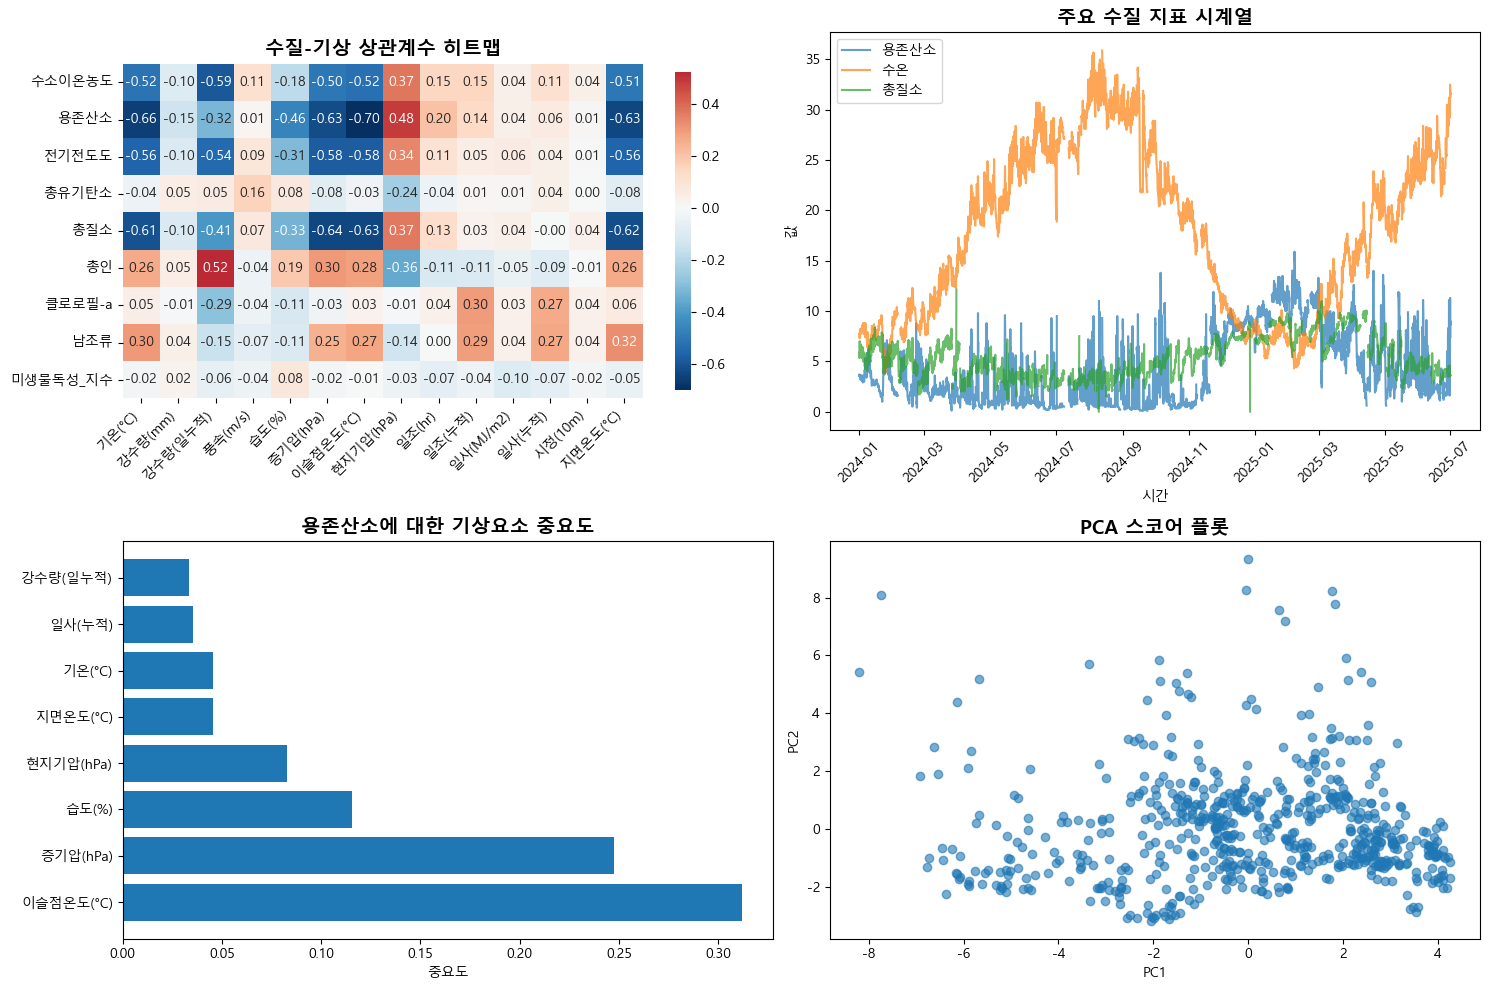

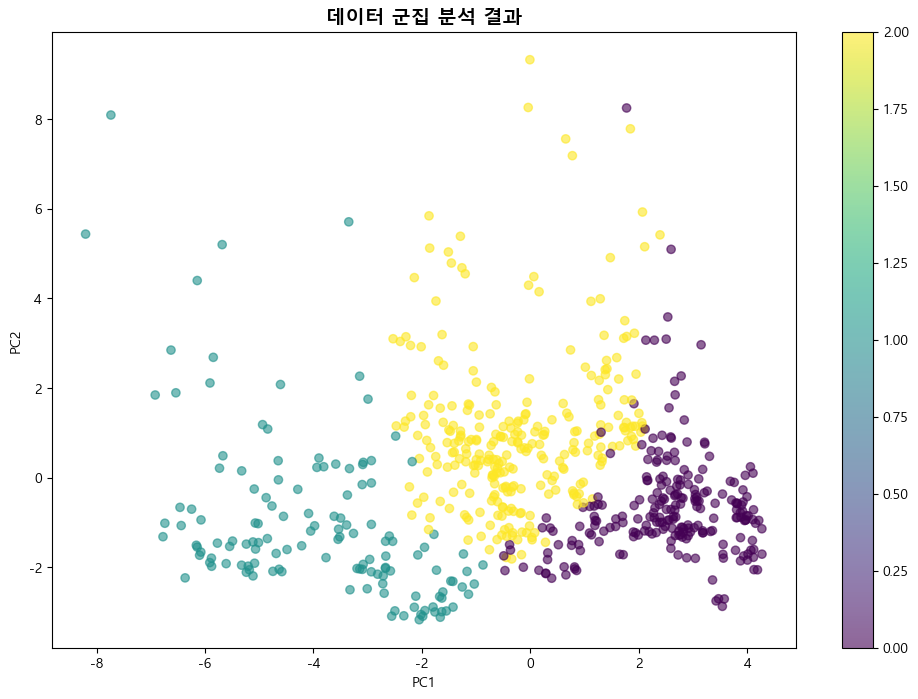


           하천 수질-기상 데이터 상관성 분석 보고서

📊 주요 발견사항:
• 유의한 상관관계 31개 발견
• 가장 강한 상관관계:
  - 용존산소 ↔ 이슬점온도(°C): r=-0.699
• 주요 영향 요인 (랜덤포레스트 기준):
  - 수소이온농도: 강수량(일누적) (중요도: 0.337)
  - 용존산소: 이슬점온도(°C) (중요도: 0.312)
  - 전기전도도: 강수량(일누적) (중요도: 0.170)

💡 분석 결과 기반 권장사항:
• 주요 기상 요인들의 지속적인 모니터링 필요
• 계절별/시간대별 세분화된 분석 권장
• 극값 데이터에 대한 별도 분석 필요
• 다변량 예측 모델 개발 가능성 검토


=== 추가 세부 분석 ===
지정된 컬럼을 찾을 수 없습니다.

=== 계절별 분석 ===
계절별 수질 지표 평균:
    수소이온농도   용존산소    전기전도도  총유기탄소    총질소     총인  클로로필-a     남조류  미생물독성_지수
계절                                                                       
가을   6.705  2.444  297.810  2.704  5.049  0.096  39.936  13.061     0.106
겨울   6.892  7.206  393.280  3.328  6.533  0.112  16.424   3.977     0.038
봄    6.836  3.934  320.320  3.927  5.520  0.121  46.453  11.499     0.404
여름   6.737  1.936  234.222  3.541  3.458  0.144  33.021  12.385     0.340

계절별 기상 데이터 평균:
    기온(°C)  강수량(mm)  강수량(일누적)  풍속(m/s)   습도(%)  증기압(hPa)  이슬점온도(°C)  \
계절                                                      

In [3]:

# 사용 예제
if __name__ == "__main__":
    # 기본 분석 실행
    analyzer = WaterQualityWeatherAnalyzer(r'C.수질측정정보\용봉측정소_2401-2506월_re.xlsx')
    results = analyzer.run_full_analysis()
    
    # 추가 분석 (예시)
    print("\n=== 추가 세부 분석 ===")
    
    # 특정 요소 간 상세 분석
    analyzer.detailed_correlation_analysis('용존산소', '기상_2.기온(°C)')
    
    # 계절별 분석
    seasonal_data = analyzer.seasonal_analysis()
    
    # 극값 분석
    extreme_data = analyzer.extreme_event_analysis()
    
    # 결과 내보내기
    analyzer.export_results('수질기상분석결과.xlsx')
    
    print("\n" + "="*50)
    print("🎯 분석 완료!")
    print("• 주 분석 결과: results 변수")
    print("• 계절별 데이터: seasonal_data 변수") 
    print("• 극값 데이터: extreme_data 변수")
    print("• 엑셀 파일: '수질기상분석결과.xlsx'")
    print("="*50)